In [2]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, Birch, MiniBatchKMeans, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

import pandas as pd 
import numpy as np
import seaborn as sb
import scipy.stats
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Exercise 1 (max 4 points)
Consider the beer dataset (beer.xlsx) which provides the price, the alcohol percentage and calorie content for a series of beer brands. Perform various cluster analysis algorithms to the data and compare the results. What is an appropriate number of clusters? Explain your answer.

In [4]:
df = pd.read_excel("beer.xlsx")
df.head()

,Beer,Country,Price,Calories,Alcohol content
0,Budweiser,USA,0.43,144,4.7
1,Lowenbrau,USA,0.48,157,4.9
2,Michelob,USA,0.50,162,5.0
3,Kronenbourg,France,0.73,170,5.2
4,Heineken,Netherlands,0.77,152,5.0


We can see that there is a variable "Country" that need to be encoded for clustering models.

In [22]:
df['Country'].unique()

array(['USA', 'France', 'Netherlands', 'Mexico', 'Germany'], dtype=object)

In [73]:
countries_ids = LabelEncoder().fit_transform(df['Country'])
df['Country_id'] = countries_ids
data = df[['Price', 'Calories', 'Alcohol content', 'Country_id']]
corr = data.corr()
corr

,Price,Calories,Alcohol content,Country_id
Price,1.000000,0.359428,0.318681,-0.826206
Calories,0.359428,1.000000,0.919873,-0.412692
Alcohol content,0.318681,0.919873,1.000000,-0.317432
Country_id,-0.826206,-0.412692,-0.317432,1.000000


High correlations between some features are detected.

First, let's calculate optimal number of features.

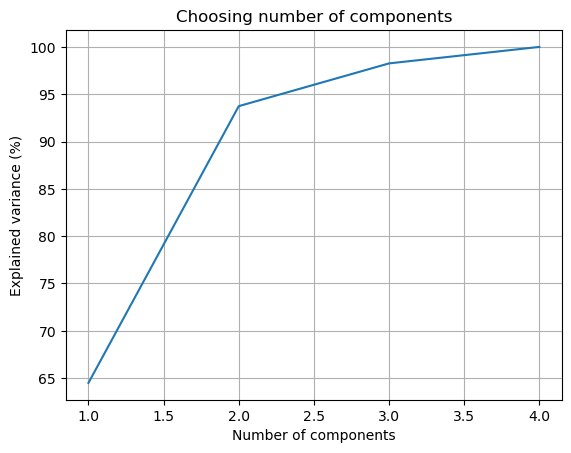

In [26]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = data
# Standardizing the features
x = StandardScaler().fit_transform(x)
df_scaled = pd.DataFrame(data = x)

from sklearn.decomposition import PCA
pca = PCA(n_components=x.shape[1])
principalComponents = pca.fit_transform(x)

plt.plot(range(1,x.shape[1]+1), 100*np.cumsum(pca.explained_variance_ratio_))
plt.title('Choosing number of components')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.grid()

In [28]:
pca = PCA(.95)
principalComponents = pca.fit_transform(x)
print('The total number of principal components is', principalComponents.shape[1])


The total number of principal components is 3


PCA says 3 features can explain 95% of variance. Nevertheless, let's assume that we need 99% of it and use all of them as generally there are too few of them.

#### Choosing number of clusters

For some methods of clustering we need to estimate the number of clusters.

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


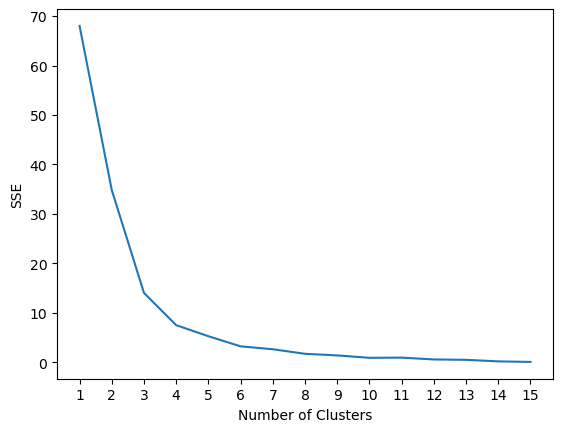

In [30]:
sse = []
nclust = 16
scaled_features = x

for k in range(1, nclust):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10,max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.plot(range(1, nclust), sse)
plt.xticks(range(1, nclust))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [32]:
kl = KneeLocator(range(1, nclust), sse, curve="convex", direction="decreasing")
kl.elbow

4

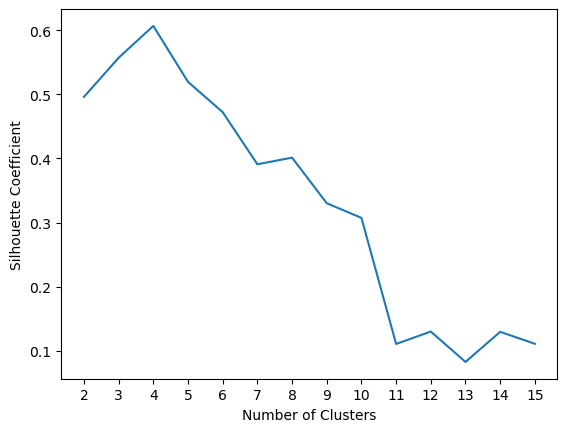

In [34]:
silhouette_coefficients = []

for k in range(2, nclust):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10,max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(2, nclust), silhouette_coefficients)
plt.xticks(range(2, nclust))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Both elbow and silhouette are suggesting 4 clusters so let's use it.

##### K-means clustering

In [42]:
kmeans = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=42)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [44]:
kmeans.inertia_

7.516215154809098

In [46]:
kmeans.cluster_centers_

array([[ 1.69401241,  0.74112415,  0.59028059, -1.60506059],
       [-0.61385815,  0.65530694,  0.58091106,  0.4938648 ],
       [-0.34293422, -0.90885473, -0.42631376,  0.4938648 ],
       [-0.55365284, -1.95811314, -2.36112236,  0.4938648 ]])

In [48]:
kmeans.n_iter_

3

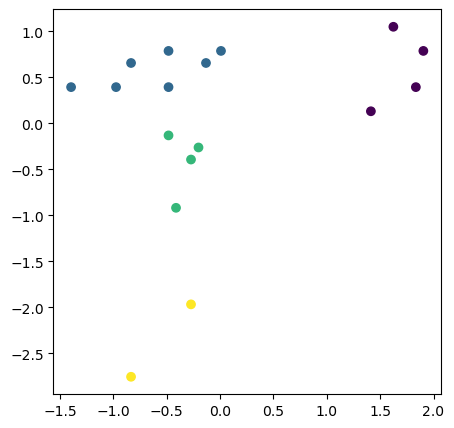

In [92]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(scaled_features[:,0], scaled_features[:,2], c=kmeans.labels_)

We used all the features for fitting but the best visualization come from Price&Calories, Alcohol Content&Country  and Price&Alcohol Content graphs. They have the lowest correlation thus their explaining power is assumed to be higher, so the clusters are more graphic. But it would be better to construct 4-dimensional scatter or choose basing on our research focus.

##### MeanShift clustering

In [55]:
print("Mean Shift method estimated ", estimate_bandwidth(scaled_features), "as the optimal bandwidth and who are we to argue") 

Mean Shift method estimated  1.6277466023051592 as the optimal bandwidth and who are we to argue


In [59]:
mshift = MeanShift()
# bandwidth = 1.5
mshift.fit(scaled_features)

MeanShift()

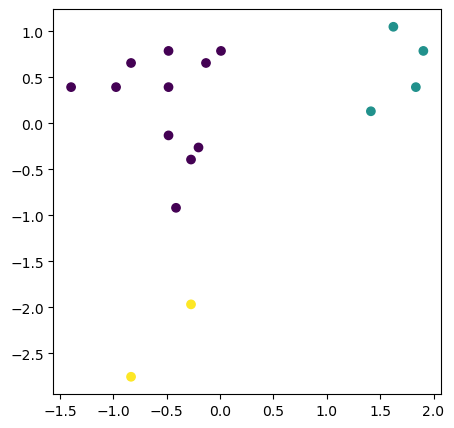

In [65]:
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(scaled_features[:,0], scaled_features[:,2], c=mshift.labels_)

With calculated bandwidth, the number of cluster from Mean Shift is 3. However, lowering bandwidth to 1.5 would give us 4 clusters, so we can argue a bit and think about what bandwidth would be the most suitable for clustering.

##### DBSCAN

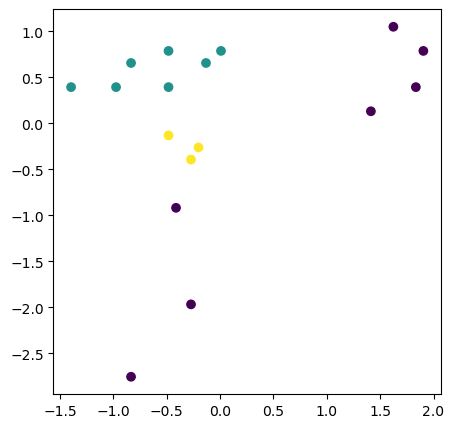

In [82]:
dbscan = DBSCAN(min_samples=3)
dbscan.fit(scaled_features)

fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(scaled_features[:,0], scaled_features[:,2], c=dbscan.labels_)

##### GaussianMixture

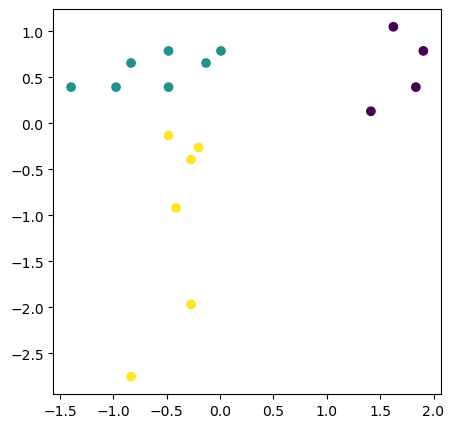

In [95]:
em_gmm = GaussianMixture(n_components=3)
em_gmm_labels=em_gmm.fit_predict(scaled_features)

fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(scaled_features[:,0], scaled_features[:,2], c=em_gmm_labels)

##### AgglomerativeClustering

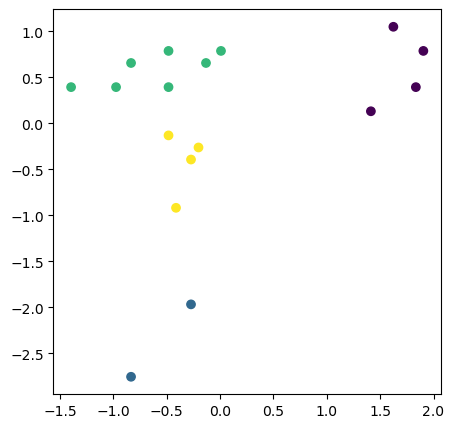

In [97]:
agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative.fit(scaled_features)

fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(scaled_features[:,0], scaled_features[:,2], c=agglomerative.labels_)

##### SpectralClustering

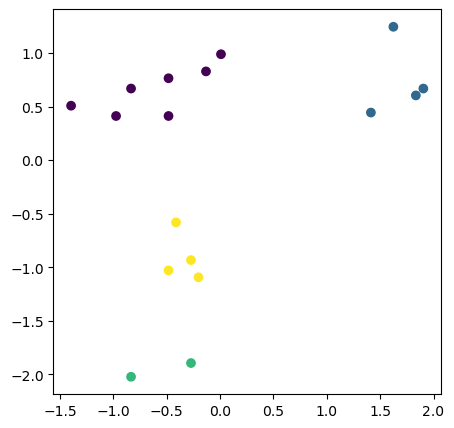

In [99]:
spectral = SpectralClustering(n_clusters=4)
spectral.fit(scaled_features)

fig = plt.figure(figsize = (5,5))
ax = fig.gca()
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=spectral.labels_)

##### Silhouette scores

In [101]:
kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_).round(2)
mshift_silhouette = silhouette_score(scaled_features, mshift.labels_).round(2)
dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round(2)
em_gmm_silhouette = silhouette_score(scaled_features, em_gmm_labels).round(2)
agglomerative_silhouette = silhouette_score(scaled_features, agglomerative.labels_).round(2)
spectral_silhouette = silhouette_score(scaled_features, spectral.labels_).round(2)

print(kmeans_silhouette, mshift_silhouette, dbscan_silhouette, em_gmm_silhouette, agglomerative_silhouette, spectral_silhouette)

0.61 0.53 0.32 0.56 0.61 0.61


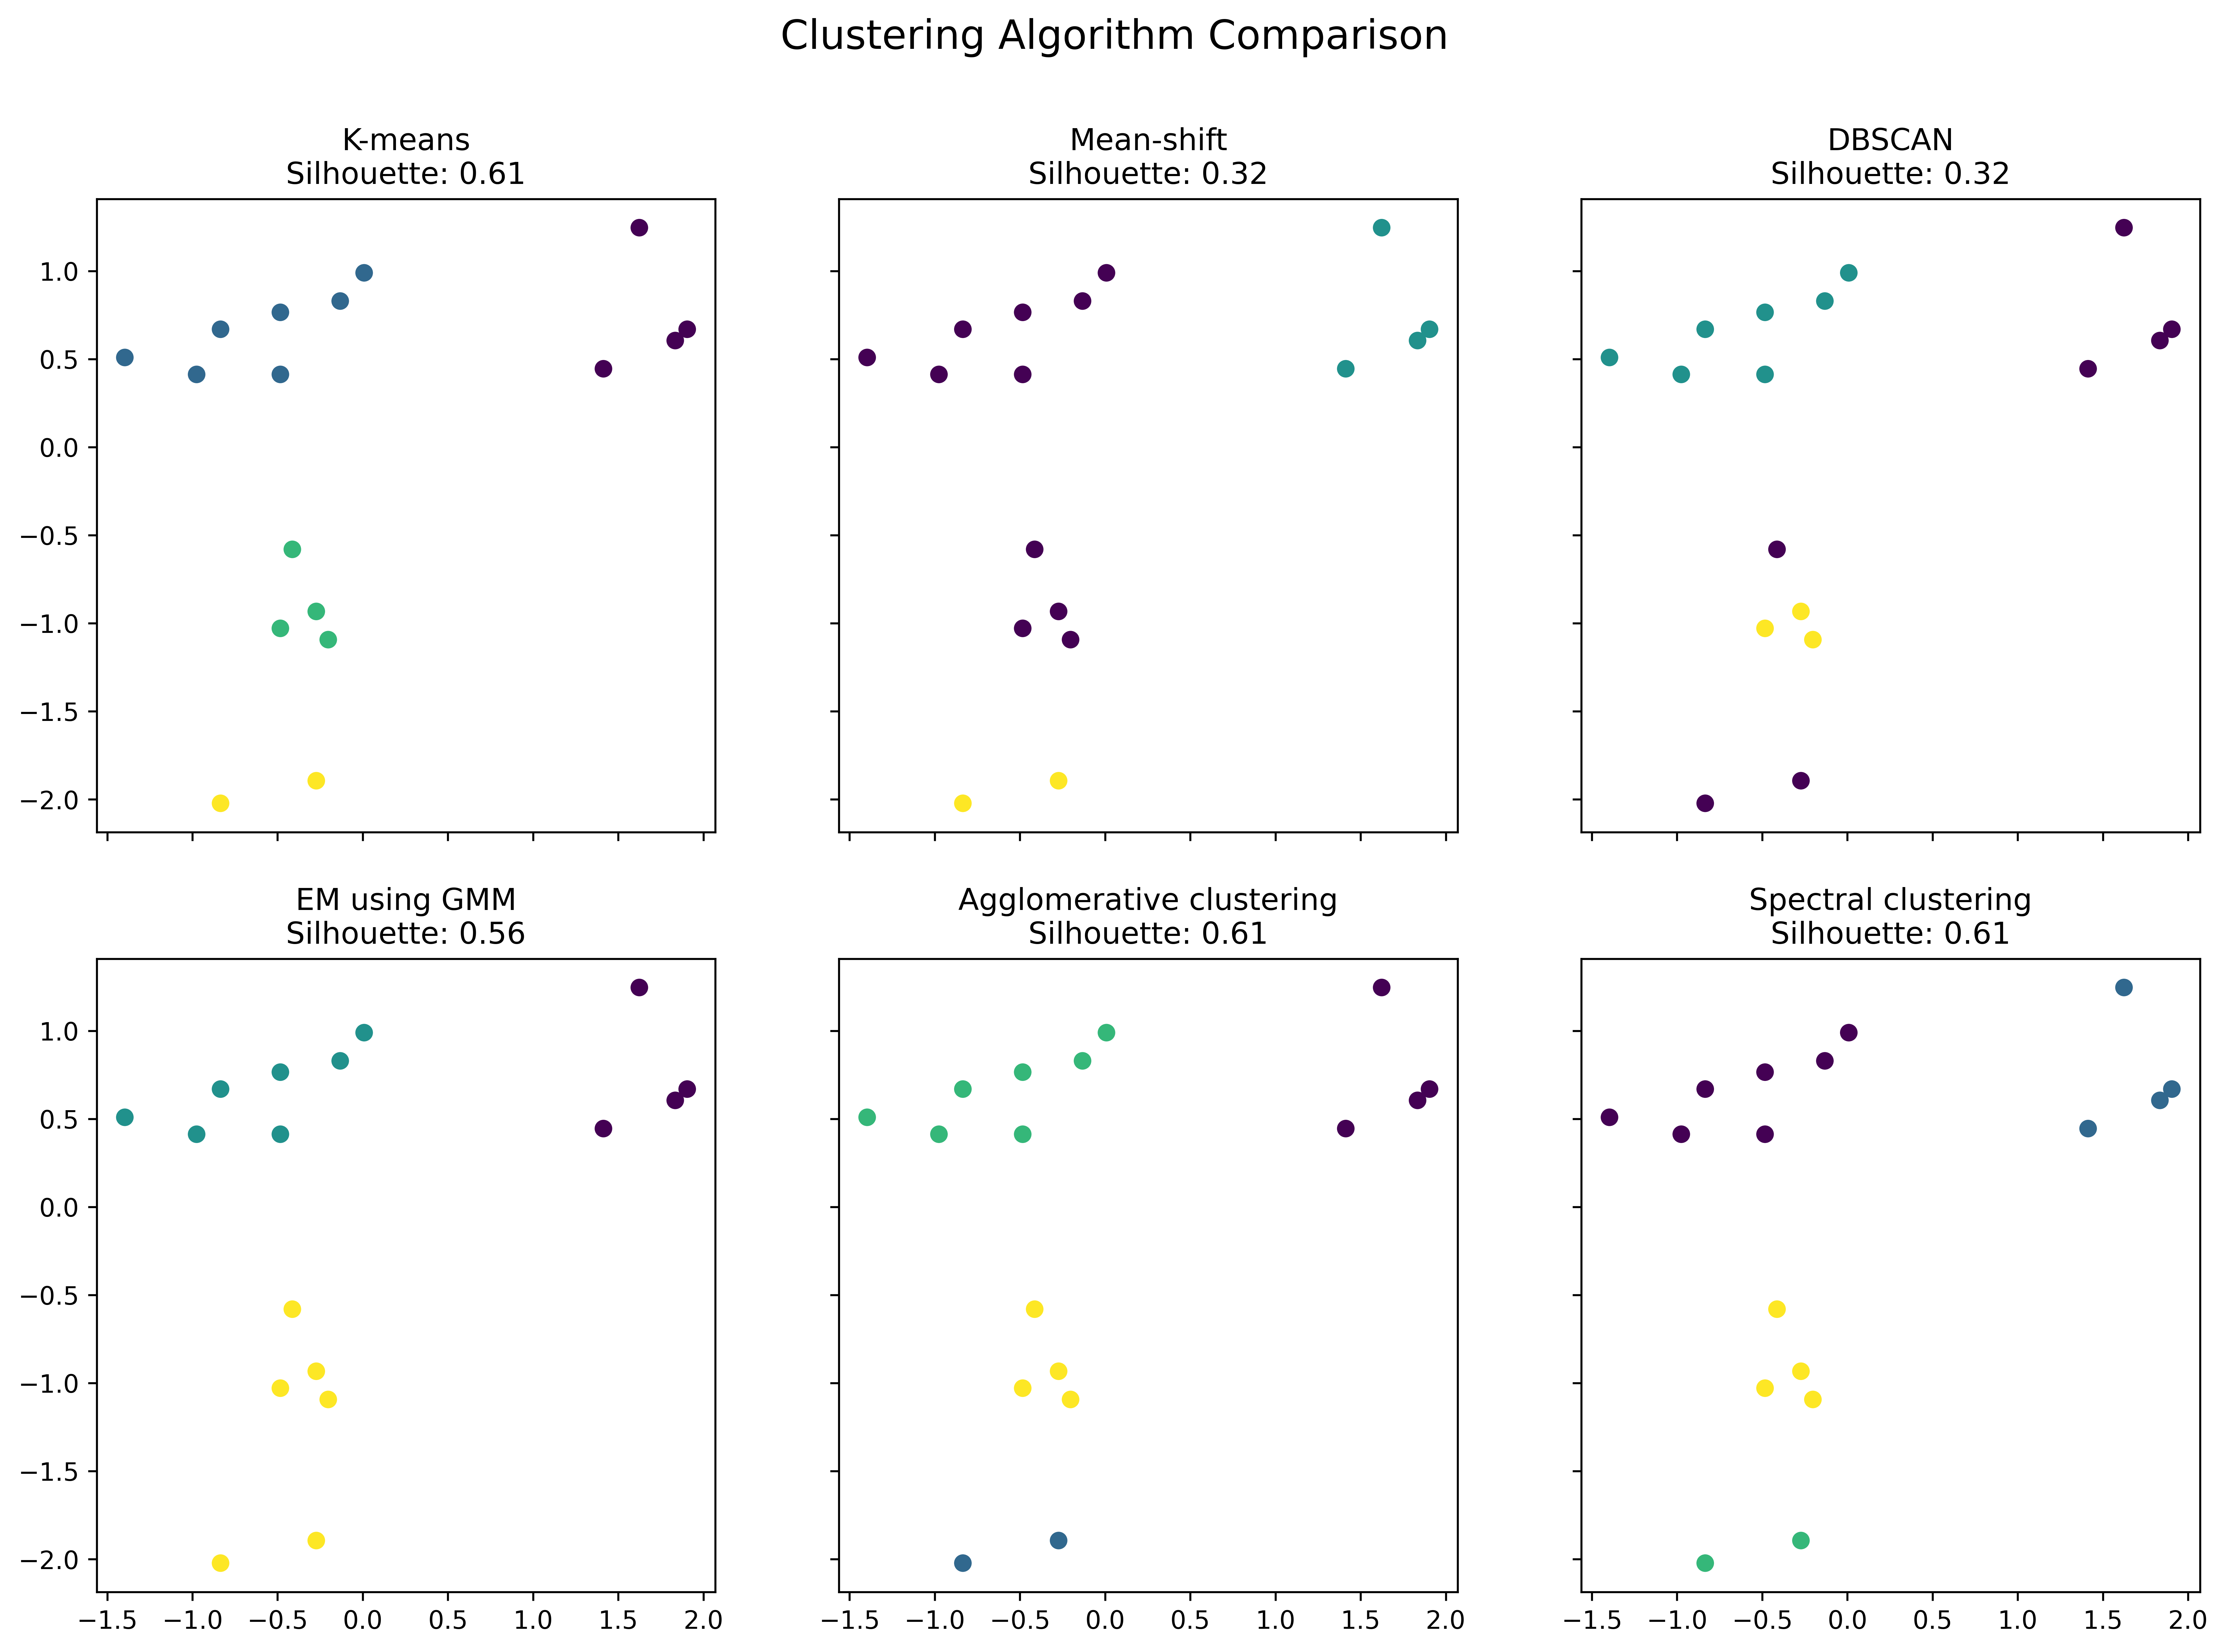

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, dpi=600)
fig.suptitle(f"Clustering Algorithm Comparison", fontsize=16)
#fte_colors = {0: "#008fd5", 1: "#fc4f30", 2: "#1f77b4", 3: "#ff7f0e",4: "#2ca02c",5: "#d62728", -1: "#9467bd"}
features = scaled_features

# The k-means plot
ax[0,0].scatter(features[:, 0], features[:, 1], c=kmeans.labels_)
ax[0,0].set_title(f"K-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})

# The mean-shift plot
ax[0,1].scatter(features[:, 0], features[:, 1], c=mshift.labels_)
ax[0,1].set_title(f"Mean-shift\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# The dbscan plot
ax[0,2].scatter(features[:, 0], features[:, 1], c=dbscan.labels_)
ax[0,2].set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# The EM using GMM
ax[1,0].scatter(features[:, 0], features[:, 1], c=em_gmm_labels)
ax[1,0].set_title(f"EM using GMM\nSilhouette: {em_gmm_silhouette}", fontdict={"fontsize": 12})

# The agglomerative plot
ax[1,1].scatter(features[:, 0], features[:, 1], c=agglomerative.labels_)
ax[1,1].set_title(f"Agglomerative clustering\nSilhouette: {agglomerative_silhouette}", fontdict={"fontsize": 12})

# The agglomerative plot
ax[1,2].scatter(features[:, 0], features[:, 1], c=spectral.labels_)
ax[1,2].set_title(f"Spectral clustering\nSilhouette: {spectral_silhouette}", fontdict={"fontsize": 12})

plt.show()

In [115]:
df['kmeans'] = kmeans.labels_
df['mshift'] = mshift.labels_
df['dbscan'] = dbscan.labels_
df['em_gmm_labels'] = em_gmm_labels
df['agglomerative'] = agglomerative.labels_
df['spectral'] = spectral.labels_
df

,Beer,Country,Price,Calories,Alcohol content,Country_id,kmeans,mshift,dbscan,em_gmm_labels,agglomerative,spectral
0,Budweiser,USA,0.43,144,4.7,4,1,0,0,1,2,0
1,Lowenbrau,USA,0.48,157,4.9,4,1,0,0,1,2,0
2,Michelob,USA,0.50,162,5.0,4,1,0,0,1,2,0
3,Kronenbourg,France,0.73,170,5.2,0,0,1,-1,0,0,1
4,Heineken,Netherlands,0.77,152,5.0,3,0,1,-1,0,0,1
5,Schmidts,USA,0.30,147,4.7,4,1,0,0,1,2,0
6,Pabst Blue Ribbon,USA,0.38,152,4.9,4,1,0,0,1,2,0
7,Miller Light,USA,0.43,99,4.3,4,2,0,1,2,3,3
8,Budweiser Light,USA,0.44,113,3.7,4,2,0,-1,2,3,3
9,Coors Light,USA,0.46,102,4.1,4,2,0,1,2,3,3


Based on Silhouette metric the best clustering method on the data is k-means, agglomerative and spectral clustering methods with identical 4 group division.

# Exercise 2 (max 6 points)
Consider the cars dataset (Cars.xlsx) which provides different characteristics for 406 cars:
- Car name
- MPG (Miles per gallon, a measure of gas mileage)
- Number of cylinders
- Displacement of the car (in cubic inches)
- Horsepower
- Weight
- Acceleration
- Model (Year)
- Origin (Nationality of manufacturer)

Perform various cluster analysis algorithms to the data and compare them. What is an appropriate number of clusters? Explain your answer. Provide an interpretation of the obtained groups of cars.

In [122]:
car = pd.read_excel("Cars.xlsx")
car.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,Chevrolet Chevelle Malibu,18.0,8,307.0,130,3504,12.0,70,US
1,Buick Skylark 320,15.0,8,350.0,165,3693,11.5,70,US
2,Plymouth Satellite,18.0,8,318.0,150,3436,11.0,70,US
3,AMC Rebel SST,16.0,8,304.0,150,3433,12.0,70,US
4,Ford Torino,17.0,8,302.0,140,3449,10.5,70,US


Let's perform similar procedures with car dataset.

In [124]:
car.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,23.051232,5.475369,194.779557,103.529557,2979.413793,15.519704,75.921182
std,8.401777,1.712160,104.922458,40.520659,847.004328,2.803359,3.748737
min,0.000000,3.000000,68.000000,0.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2226.500000,13.700000,73.000000
50%,22.350000,4.000000,151.000000,93.500000,2822.500000,15.500000,76.000000
75%,29.000000,8.000000,302.000000,129.000000,3618.250000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [126]:
print(car['Origin'].unique())
print(car.columns)

origin_ids = LabelEncoder().fit_transform(car['Origin'])

['US' 'Europe' 'Japan']
Index(['Car', 'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model', 'Origin'],
      dtype='object')


In [128]:
car['Origin_id'] = origin_ids
features = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model', 'Origin_id']
data = car[features]
corr = data.corr()
corr

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin_id
MPG,1.000000,-0.735563,-0.764277,-0.726670,-0.787510,0.424490,0.586234,-0.423525
Cylinders,-0.735563,1.000000,0.951787,0.823467,0.895220,-0.522452,-0.360762,0.558388
Displacement,-0.764277,0.951787,1.000000,0.873758,0.932475,-0.557984,-0.381714,0.595359
Horsepower,-0.726670,0.823467,0.873758,1.000000,0.840811,-0.682047,-0.419929,0.428593
Weight,-0.787510,0.895220,0.932475,0.840811,1.000000,-0.430086,-0.315389,0.522931
Acceleration,0.424490,-0.522452,-0.557984,-0.682047,-0.430086,1.000000,0.301992,-0.272942
Model,0.586234,-0.360762,-0.381714,-0.419929,-0.315389,0.301992,1.000000,-0.079167
Origin_id,-0.423525,0.558388,0.595359,0.428593,0.522931,-0.272942,-0.079167,1.000000


There are also several features that correlate significantly, so lets choose number of components that have high explanatory power.

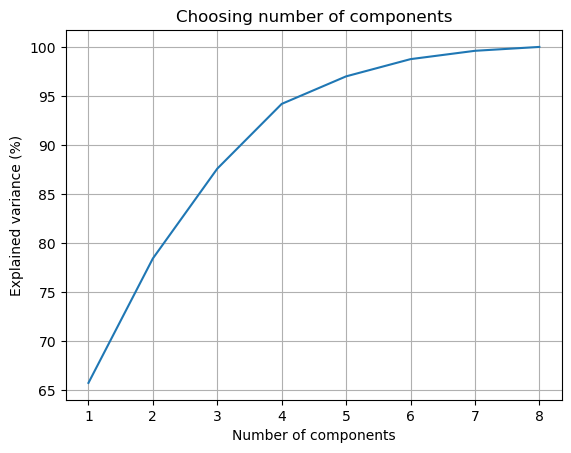

In [131]:
# Standardizing the features
x = StandardScaler().fit_transform(data)
df_scaled = pd.DataFrame(data = x, columns = features)

from sklearn.decomposition import PCA
pca = PCA(n_components=x.shape[1])
principalComponents = pca.fit_transform(x)

plt.plot(range(1,x.shape[1]+1), 100*np.cumsum(pca.explained_variance_ratio_))
plt.title('Choosing number of components')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.grid()

In [137]:
pca = PCA(.95)
principalComponents = pca.fit_transform(x)
print('The total number of principal components is', principalComponents.shape[1])

The total number of principal components is 5


In [139]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

principalDf

,PC1,PC2,PC3,PC4,PC5
0,2.671856,0.739904,-0.177430,-0.734052,-0.692849
1,3.464885,0.808368,-0.379762,-0.490049,-0.530792
2,2.981805,0.822598,-0.598315,-0.774464,-0.692972
3,2.913105,0.835148,-0.235339,-0.673588,-0.526285
4,2.918914,0.880461,-0.651787,-0.880098,-0.513267
...,...,...,...,...,...
401,-1.187255,-1.529158,-0.439066,-0.308495,0.673946
402,-4.336612,-0.944845,1.082615,2.005188,-1.392084
403,-1.285594,-1.341207,-1.870746,-0.997687,0.436073
404,-1.759623,-1.681855,0.415838,-0.112304,0.457916


##### Number of Clusters

Optimal Number of Clusters 3


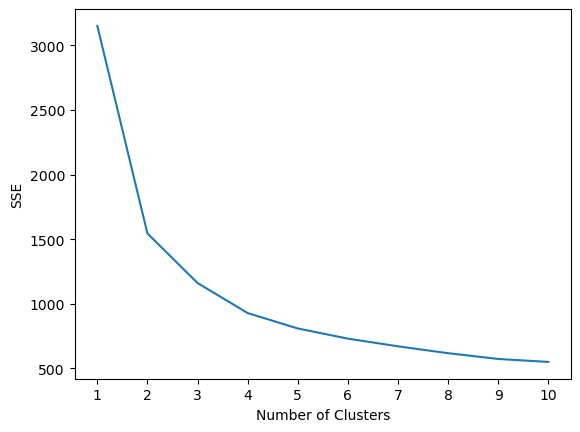

In [145]:
sse = []
nclust = 11
scaled_features = principalDf.to_numpy()

for k in range(1, nclust):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10,max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, nclust), sse, curve="convex", direction="decreasing")
print("Optimal Number of Clusters", kl.elbow)

plt.plot(range(1, nclust), sse)
plt.xticks(range(1, nclust))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

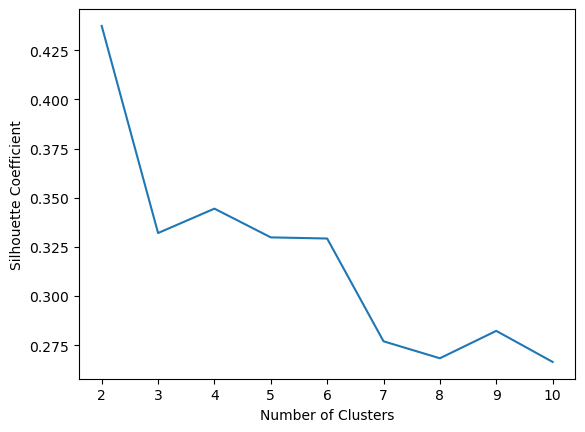

In [147]:
silhouette_coefficients = []

for k in range(2, nclust):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10,max_iter=300,random_state=42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(2, nclust), silhouette_coefficients)
plt.xticks(range(2, nclust))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This time number of clusters is not the same from elbow and silhouette. The elbow metric suggests 3 clusters while silhouette offers 2 or 4 as optimal. We will try all 3 in k-means and 4 in Agglomerative clustering (as silhouette is our metric for comparison), then illustrate it on a graph.

In [205]:
# K-means
kmeans2 = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
kmeans2.fit(scaled_features)

kmeans3 = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
kmeans3.fit(scaled_features)

kmeans4 = KMeans(init="random",n_clusters=4,n_init=10,max_iter=300,random_state=42)
kmeans4.fit(scaled_features)
#
mshift = MeanShift()
mshift.fit(scaled_features)

#
dbscan = DBSCAN(min_samples=3)
dbscan.fit(scaled_features)

#
em_gmm = GaussianMixture(n_components=3)
em_gmm_labels=em_gmm.fit_predict(scaled_features)

#
agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative.fit(scaled_features)

#
spectral = SpectralClustering(n_clusters=3)
spectral.fit(scaled_features)

SpectralClustering(n_clusters=3)

In [207]:
kmeans2_silhouette = silhouette_score(scaled_features, kmeans2.labels_).round(2)
kmeans3_silhouette = silhouette_score(scaled_features, kmeans3.labels_).round(2)
kmeans4_silhouette = silhouette_score(scaled_features, kmeans4.labels_).round(2)
mshift_silhouette = silhouette_score(scaled_features, mshift.labels_).round(2)
dbscan_silhouette = silhouette_score(scaled_features, dbscan.labels_).round(2)
em_gmm_silhouette = silhouette_score(scaled_features, em_gmm_labels).round(2)
agglomerative_silhouette = silhouette_score(scaled_features, agglomerative.labels_).round(2)
spectral_silhouette = silhouette_score(scaled_features, spectral.labels_).round(2)

print(kmeans2_silhouette,kmeans3_silhouette,kmeans4_silhouette, mshift_silhouette, dbscan_silhouette, em_gmm_silhouette, agglomerative_silhouette, spectral_silhouette)

0.44 0.33 0.34 0.43 -0.1 0.32 0.31 0.32


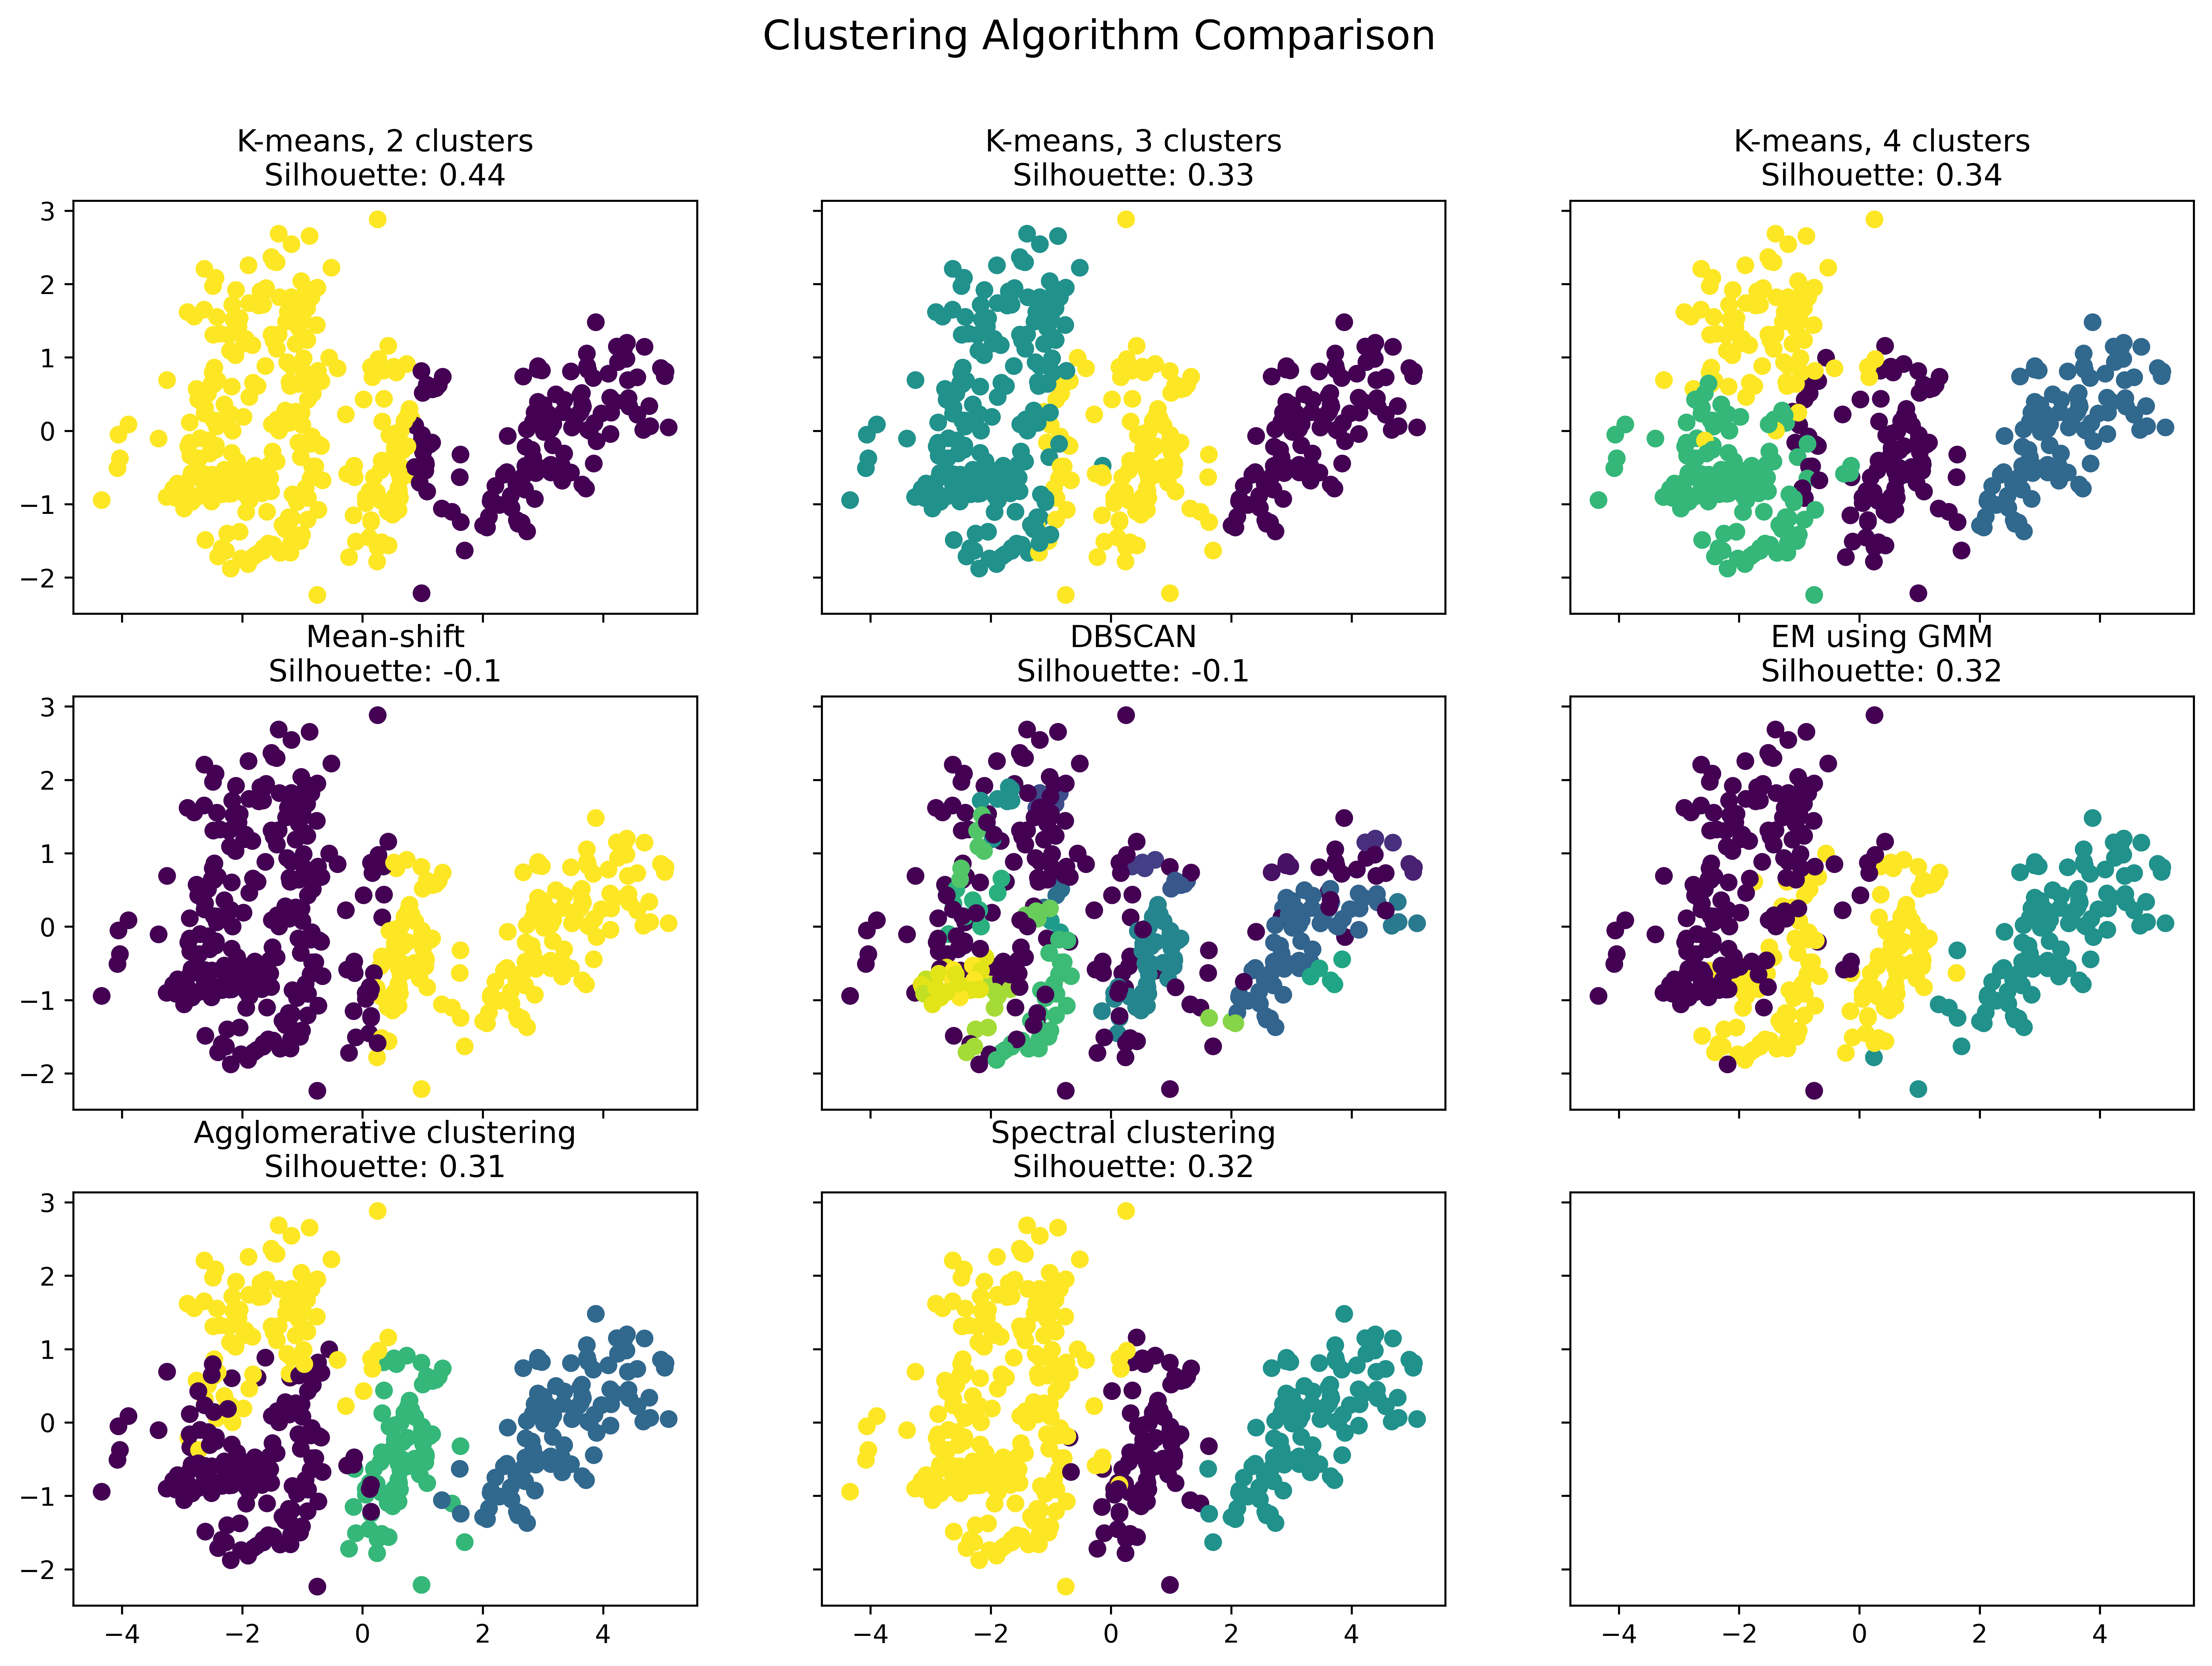

In [213]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True, dpi=600)
fig.suptitle(f"Clustering Algorithm Comparison", fontsize=16)
#fte_colors = {0: "#008fd5", 1: "#fc4f30", 2: "#1f77b4", 3: "#ff7f0e",4: "#2ca02c",5: "#d62728", -1: "#9467bd"}
features = scaled_features

# The k-means plot, 2 clusters
ax[0,0].scatter(features[:, 0], features[:, 1], c=kmeans2.labels_)
ax[0,0].set_title(f"K-means, 2 clusters\nSilhouette: {kmeans2_silhouette}", fontdict={"fontsize": 12})

# The k-means plot, 3 clusters
ax[0,1].scatter(features[:, 0], features[:, 1], c=kmeans3.labels_)
ax[0,1].set_title(f"K-means, 3 clusters\nSilhouette: {kmeans3_silhouette}", fontdict={"fontsize": 12})

# The k-means plot, 4 clusters
ax[0,2].scatter(features[:, 0], features[:, 1], c=kmeans4.labels_)
ax[0,2].set_title(f"K-means, 4 clusters\nSilhouette: {kmeans4_silhouette}", fontdict={"fontsize": 12})

# The mean-shift plot
ax[1,0].scatter(features[:, 0], features[:, 1], c=mshift.labels_)
ax[1,0].set_title(f"Mean-shift\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# The dbscan plot
ax[1,1].scatter(features[:, 0], features[:, 1], c=dbscan.labels_)
ax[1,1].set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# The EM using GMM
ax[1,2].scatter(features[:, 0], features[:, 1], c=em_gmm_labels)
ax[1,2].set_title(f"EM using GMM\nSilhouette: {em_gmm_silhouette}", fontdict={"fontsize": 12})

# The agglomerative plot
ax[2,0].scatter(features[:, 0], features[:, 1], c=agglomerative.labels_)
ax[2,0].set_title(f"Agglomerative clustering\nSilhouette: {agglomerative_silhouette}", fontdict={"fontsize": 12})

# The agglomerative plot
ax[2,1].scatter(features[:, 0], features[:, 1], c=spectral.labels_)
ax[2,1].set_title(f"Spectral clustering\nSilhouette: {spectral_silhouette}", fontdict={"fontsize": 12})

plt.show()

Silhouette suggests k-means with 2 clusters as the most informative. Odd that in graph m-shift is very similar to it but has negative score. But from illustrations, 2 groups seem to intercept less with each other than other clustering.

In [216]:
car['kmeans2'] = kmeans2.labels_
car['kmeans3'] = kmeans2.labels_
car['kmeans4'] = kmeans2.labels_
car['mshift'] = mshift.labels_
car['dbscan'] = dbscan.labels_
car['em_gmm_labels'] = em_gmm_labels
car['agglomerative'] = agglomerative.labels_
car['spectral'] = spectral.labels_
car

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin,Origin_id,kmeans2,kmeans3,kmeans4,mshift,dbscan,em_gmm_labels,agglomerative,spectral
0,Chevrolet Chevelle Malibu,18.0,8,307.0,130,3504,12.0,70,US,2,0,0,0,1,0,1,1,1
1,Buick Skylark 320,15.0,8,350.0,165,3693,11.5,70,US,2,0,0,0,1,-1,1,1,1
2,Plymouth Satellite,18.0,8,318.0,150,3436,11.0,70,US,2,0,0,0,1,0,1,1,1
3,AMC Rebel SST,16.0,8,304.0,150,3433,12.0,70,US,2,0,0,0,1,0,1,1,1
4,Ford Torino,17.0,8,302.0,140,3449,10.5,70,US,2,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,Ford Mustang GL,27.0,4,140.0,86,2790,15.6,82,US,2,1,1,1,0,14,2,0,2
402,Volkswagen Pickup,44.0,4,97.0,52,2130,24.6,82,Europe,0,1,1,1,0,-1,0,0,2
403,Dodge Rampage,32.0,4,135.0,84,2295,11.6,82,US,2,1,1,1,0,-1,2,0,2
404,Ford Ranger,28.0,4,120.0,79,2625,18.6,82,US,2,1,1,1,0,14,2,0,2


In [236]:
print("Всего у mshift кластеров:", len(np.unique(mshift.labels_)), "\nВсего у dbscan кластеров:", len(np.unique(dbscan.labels_)), "\nВсего у em_gmm кластеров:", len(np.unique(em_gmm_labels)))

Всего у mshift кластеров: 2 
Всего у dbscan кластеров: 23 
Всего у em_gmm кластеров: 3
